# Uncertainty estimates from CIFAR 10

In [1]:
import sys
sys.path.append("../") 

In [2]:
from __future__ import division

import argparse, time, logging, random, math

import numpy as np
import mxnet as mx

from mxnet import gluon, nd
from mxnet import autograd as ag
from mxnet.gluon import nn
from mxnet.gluon.data.vision import transforms

In [3]:
transform_train = transforms.Compose([
    # Randomly crop an area and resize it to be 32x32, then pad it to be 40x40
    transforms.RandomCrop(32, pad=4),
    # Randomly flip the image horizontally
    transforms.RandomFlipLeftRight(),
    # Transpose the image from height*width*num_channels to num_channels*height*width
    # and map values from [0, 255] to [0,1]
    transforms.ToTensor(),
    # Normalize the image with mean and standard deviation calculated across all images
    transforms.Normalize([0.4914, 0.4822, 0.4465], [0.2023, 0.1994, 0.2010])
])

In [4]:
transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.4914, 0.4822, 0.4465], [0.2023, 0.1994, 0.2010])
])

In [6]:
# Batch Size for Each GPU
num_gpus = 1
model_ctx = [mx.gpu(i) for i in range(num_gpus)]

per_device_batch_size = 128
# Number of data loader workers
num_workers = 8
# Calculate effective total batch size
batch_size = per_device_batch_size * num_gpus

# Set train=True for training data
# Set shuffle=True to shuffle the training data
train_data = gluon.data.DataLoader(
    gluon.data.vision.CIFAR10(train=True).transform_first(transform_train),
    batch_size=batch_size, shuffle=True, last_batch='discard', num_workers=num_workers)

# Set train=False for validation data
val_data = gluon.data.DataLoader(
    gluon.data.vision.CIFAR10(train=False).transform_first(transform_test),
    batch_size=batch_size, shuffle=False, num_workers=num_workers)

# SGD Resnet 18

In [7]:
import mxnet as mx
from mxnet import nd, autograd, gluon
model_ctx=mx.gpu()
hyper={'alpha':10.}
in_units=(32,32)
out_units=10
n_layers=18
pre_trained=False

In [13]:
import mxnet as mx
from hamiltonian.inference.sgd import sgd
from hamiltonian.models.softmax import resnet_softmax

model=resnet_softmax(hyper,in_units,out_units,n_layers,pre_trained,ctx=model_ctx)
inference=sgd(model,model.par,step_size=0.0001,ctx=model_ctx)

In [14]:
import hamiltonian
import importlib

try:
    importlib.reload(hamiltonian.models.softmax)
    importlib.reload(hamiltonian.inference.sgd)
    print('modules re-loaded')
except:
    print('no modules loaded yet')


modules re-loaded


In [15]:
par,loss=inference.fit(epochs=100,batch_size=batch_size,data_loader=train_data,verbose=True)

  1%|          | 1/100 [02:44<4:32:10, 164.95s/it]

loss: 3.6920


 11%|█         | 11/100 [1:01:25<9:15:47, 374.69s/it]

loss: 2.5808


 21%|██        | 21/100 [2:02:59<7:39:08, 348.71s/it]

loss: 2.3607


 31%|███       | 31/100 [2:58:55<6:25:28, 335.19s/it]

loss: 2.2375


 41%|████      | 41/100 [3:55:38<5:35:29, 341.18s/it]

loss: 2.1467


 51%|█████     | 51/100 [4:51:15<4:32:39, 333.87s/it]

loss: 2.0655


 61%|██████    | 61/100 [5:46:47<3:36:12, 332.63s/it]

loss: 2.0025


 71%|███████   | 71/100 [6:40:49<2:35:15, 321.24s/it]

loss: 1.9592


 81%|████████  | 81/100 [7:32:54<1:38:19, 310.49s/it]

loss: 1.9103


 91%|█████████ | 91/100 [8:23:24<45:11, 301.27s/it]  

loss: 1.8615


100%|██████████| 100/100 [9:07:34<00:00, 328.54s/it]


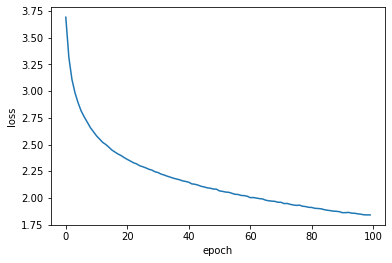

In [16]:
import matplotlib.pyplot as plt

plt.plot(loss)
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

In [17]:
total_labels=[]
total_samples=[]
for X_test,y_test in val_data:
    X_test=X_test.as_in_context(model_ctx)
    y_hat=model.predict(model.par,X_test)
    if X_test.shape[0]==batch_size:
        samples=[]
        for _ in range(100):
            samples.append(y_hat.sample().asnumpy())
        total_samples.append(np.asarray(samples))
        total_labels.append(y_test.asnumpy())
total_samples=np.concatenate(total_samples,axis=1)
total_labels=np.concatenate(total_labels)    

In [18]:
y_hat=np.quantile(total_samples,.1,axis=0)

In [19]:
from sklearn.metrics import classification_report

print(classification_report(np.int32(total_labels),np.int32(y_hat)))

              precision    recall  f1-score   support

           0       0.66      0.92      0.77       998
           1       0.80      0.90      0.85       999
           2       0.60      0.76      0.67       999
           3       0.51      0.71      0.60       997
           4       0.74      0.71      0.73      1000
           5       0.76      0.50      0.60       997
           6       0.90      0.74      0.81      1000
           7       0.93      0.69      0.79       997
           8       0.92      0.82      0.87       997
           9       0.94      0.73      0.82      1000

    accuracy                           0.75      9984
   macro avg       0.78      0.75      0.75      9984
weighted avg       0.78      0.75      0.75      9984

